#### 1. Identificar y entender valores faltantes

##### Libreria 

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [29]:
# 1. Crear un dataset ficticio para el ejemplo
data = {
    'edad': [25, 30, None, 40, 35, None, 28, 50, 45, None],
    'salario': [30000, None, 45000, 50000, 35000, 40000, None, 60000, 55000, 32000],
    'genero': ['M', 'F', 'F', None, 'M', 'F', 'M', 'F', None, 'M'],
    'ciudad': ['Lima', 'Arequipa', 'Lima', 'Cusco', None, 'Trujillo', 'Lima', 'Arequipa', 'Cusco', 'Lima']
}

df = pd.DataFrame(data)
df.head(20)

,edad,salario,genero,ciudad
0,25.0,30000.0,M,Lima
1,30.0,NaN,F,Arequipa
2,NaN,45000.0,F,Lima
3,40.0,50000.0,None,Cusco
4,35.0,35000.0,M,None
5,NaN,40000.0,F,Trujillo
6,28.0,NaN,M,Lima
7,50.0,60000.0,F,Arequipa
8,45.0,55000.0,None,Cusco
9,NaN,32000.0,M,Lima


In [30]:
# 2. Identificar valores faltantes
print("Cantidad de valores faltantes por columna:")
print(df.isnull().sum()/len(df) * 100)
print("\nPorcentaje de valores faltantes por columna:")
print(df.isnull().mean() * 100)

Cantidad de valores faltantes por columna:
edad       30.0
salario    20.0
genero     20.0
ciudad     10.0
dtype: float64

Porcentaje de valores faltantes por columna:
edad       30.0
salario    20.0
genero     20.0
ciudad     10.0
dtype: float64


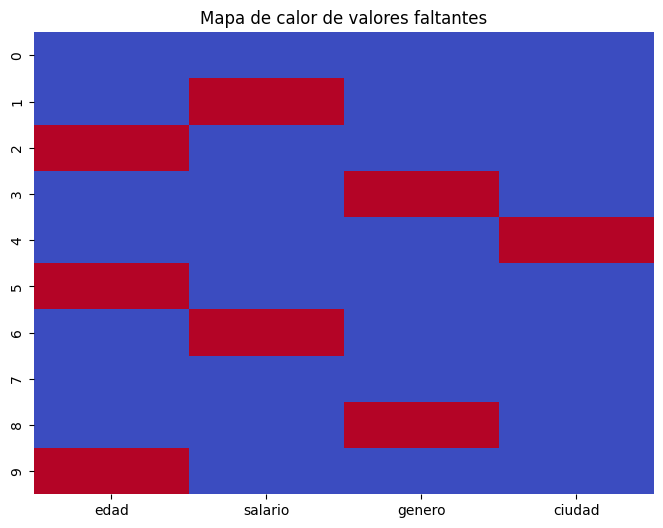

In [32]:
# 3. Visualizar valores faltantes con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm')
plt.title("Mapa de calor de valores faltantes")
plt.show()

In [11]:
# 4. Analizar mecanismo de faltantes (ejemplo exploratorio)
# Hipótesis: ¿Los faltantes en 'salario' están relacionados con 'genero'?
# Comparar distribuciones de 'genero' en filas con y sin 'salario' faltante
salario_missing = df[df['salario'].isnull()]['genero'].value_counts(normalize=True)
salario_present = df[df['salario'].notnull()]['genero'].value_counts(normalize=True)
print("\nDistribución de 'genero' cuando 'salario' está faltante:")
print(salario_missing)
print("\nDistribución de 'genero' cuando 'salario' está presente:")
print(salario_present)


Distribución de 'genero' cuando 'salario' está faltante:
genero
F    0.5
M    0.5
Name: proportion, dtype: float64

Distribución de 'genero' cuando 'salario' está presente:
genero
M    0.5
F    0.5
Name: proportion, dtype: float64


In [12]:
# 5. Prueba estadística para verificar si los faltantes son MCAR
# Comparar 'edad' en filas con y sin 'salario' faltante
edad_con_salario = df[df['salario'].notnull()]['edad'].dropna()
edad_sin_salario = df[df['salario'].isnull()]['edad'].dropna()
t_stat, p_value = ttest_ind(edad_con_salario, edad_sin_salario, equal_var=False)
print(f"\nPrueba t para 'edad' con/sin 'salario' faltante: p-valor = {p_value:.4f}")
if p_value < 0.05:
    print("Evidencia de que los faltantes en 'salario' no son MCAR (puede ser MAR).")
else:
    print("No hay evidencia suficiente para rechazar MCAR.")


Prueba t para 'edad' con/sin 'salario' faltante: p-valor = 0.0803
No hay evidencia suficiente para rechazar MCAR.


MNAR: Si sospechas MNAR (e.g., personas con salarios altos no reportan), explora proxies (otras variables correlacionadas) o considera sensibilidad (imputar rangos altos/bajos y comparar resultados).
Siguientes Pasos: Basado en el análisis, decide si eliminar filas/columnas o imputar. Por ejemplo, si edad tiene 30% faltantes pero es MCAR, eliminar filas puede ser aceptable. Si es MAR, prueba KNNImputer (puedo darte un ejemplo si lo necesitas).

Siguientes Pasos: Basado en el análisis, decide si eliminar filas/columnas o imputar. Por ejemplo, si edad tiene 30% faltantes pero es MCAR, eliminar filas puede ser aceptable. Si es MAR, prueba KNNImputer (puedo darte un ejemplo si lo necesitas)

**Faltantes Completamente al Azar (MCAR)**: la falta de datos es ajena a los datos mismos. Su localización en el conjunto de datos es completamente al azar, es decir, la probabilidad de que falte un valor es la misma para todas las observaciones y no esta relacionada con ninguna característica de los datos. Un ejemplo es una balanza que se queda sin batería y no registra el peso de algunos objetos. Es completamente aleatorio, no tiene preferencia por algunos registros.

**Faltantes al Azar (MAR)**: La falta de datos depende de algunos valores observados. La probabilidad de que falte un valor puede variar según las observaciones, pero solo en función de las variables que tienen valores completos. Por ejemplo, si en una encuesta sobre hábitos alimenticios algunas personas no responden a la pregunta sobre el consumo de carnes por razones éticas o religiosas, serán de tipo MAR si se conoce la variable que indica la condición ética o religiosa de los encuestados.

**Faltantes No al Azar (MNAR)**: La localización de los valores faltantes dependen de los valores en sí mismo. La probabilidad de que falte un valor puede variar según las observaciones y esta relacionada con la variable que tiene valores faltantes. Un ejemplo es una encuesta sobre ingresos donde algunas personas no responden a la pregunta sobre el salario por privacidad. En este caso son de tipo MNAR porque el salario esta correlacionado con la intención de responder.

<img src="./image.png" width="500">

Estos mecanismos importan porque:

Bajo MCAR, métodos simples como eliminar casos o imputar con la media funcionan sin sesgo.

Bajo MAR, se recomiendan imputaciones avanzadas (e.g., regresión o k-NN).

Bajo MNAR, es difícil; a menudo se requiere modelado especial (e.g., selection models) o suposiciones "what-if".

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import chi2_contingency

df = pd.read_csv("./data/boston.csv")

print("Porcentaje de valores faltantes por columna (solo con nulos):")
missing_pct = df.isnull().sum() / len(df) * 100
missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_cols)

Porcentaje de valores faltantes por columna (solo con nulos):
Series([], dtype: float64)


---

In [22]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [23]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [18]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


----

#### OMITIR

Porcentaje de valores faltantes por columna (tras introducir nulos):
CRIM    22.727273
NOX      2.964427
TAX      0.988142
dtype: float64


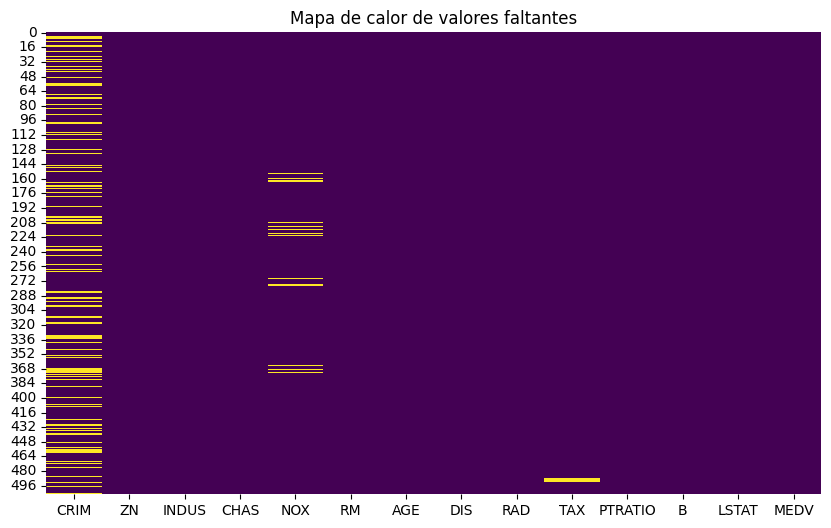

In [34]:
import pandas as pd
import numpy as np

# Configurar semilla para reproducibilidad
np.random.seed(42)

# Hacer una copia del dataset original
df_original = df.copy()

# Introducir valores faltantes
# a) MCAR: 20% faltantes en 'crim' (aleatorio)
mcar_mask = np.random.choice([True, False], size=len(df), p=[0.2, 0.8])
df.loc[mcar_mask, 'CRIM'] = np.nan

# b) MAR: Faltantes en 'nox' si chas=1 (40% probabilidad)
mar_mask = (df['CHAS'] == 1) & (np.random.random(len(df)) < 0.4)
df.loc[mar_mask, 'NOX'] = np.nan

# c) MNAR: Faltantes en 'tax' para valores altos (> percentil 75)
mnar_mask = df['TAX'] > df['TAX'].quantile(0.75)
df.loc[mnar_mask, 'TAX'] = np.nan

# Verificar valores faltantes
print("Porcentaje de valores faltantes por columna (tras introducir nulos):")
missing_pct = df.isnull().sum() / len(df) * 100
missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_cols)

# Visualizar con heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de calor de valores faltantes")
plt.show()

In [35]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,NaN,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [36]:
df.shape

(506, 14)

In [38]:
506-391

115

In [39]:
115/506   * 100

22.727272727272727

In [37]:
# INTRODUCIR VALORES EN CRIM (MCAR)

df_copy = df.copy()

df_listwise = df_copy.dropna(subset=['CRIM'])

df_listwise.shape

(391, 14)

In [40]:
df_copy_2 = df.copy()

df_copy_2['CRIM'].fillna(df_copy_2['CRIM'].mean(), inplace=True)

C:\Users\CristiamAlbertoLoaiz\AppData\Local\Temp\ipykernel_35796\1783254079.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_2['CRIM'].fillna(df_copy_2['CRIM'].mean(), inplace=True)


In [41]:
df_copy_2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,3.57559,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Text(0.5, 1.0, 'Valores de CRIM tras imputación con la media')

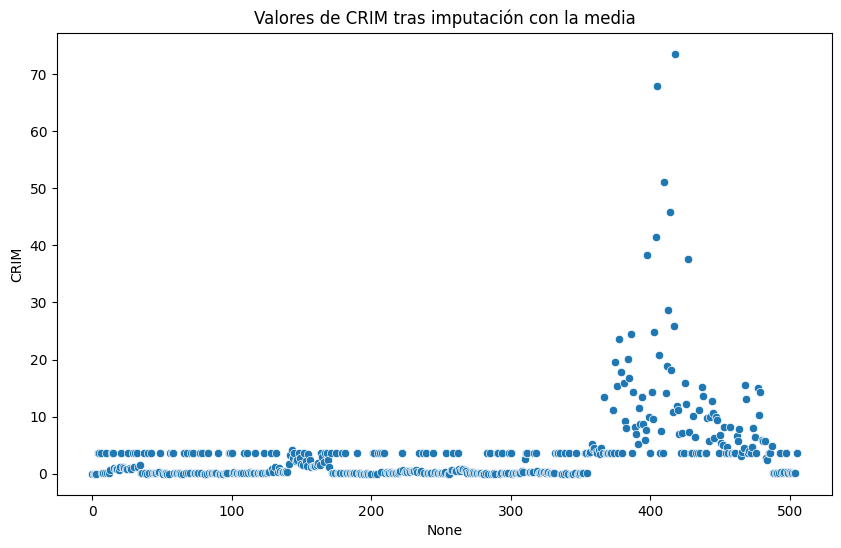

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_copy_2.index, y='CRIM', data=df_copy_2)
plt.title("Valores de CRIM tras imputación con la media")

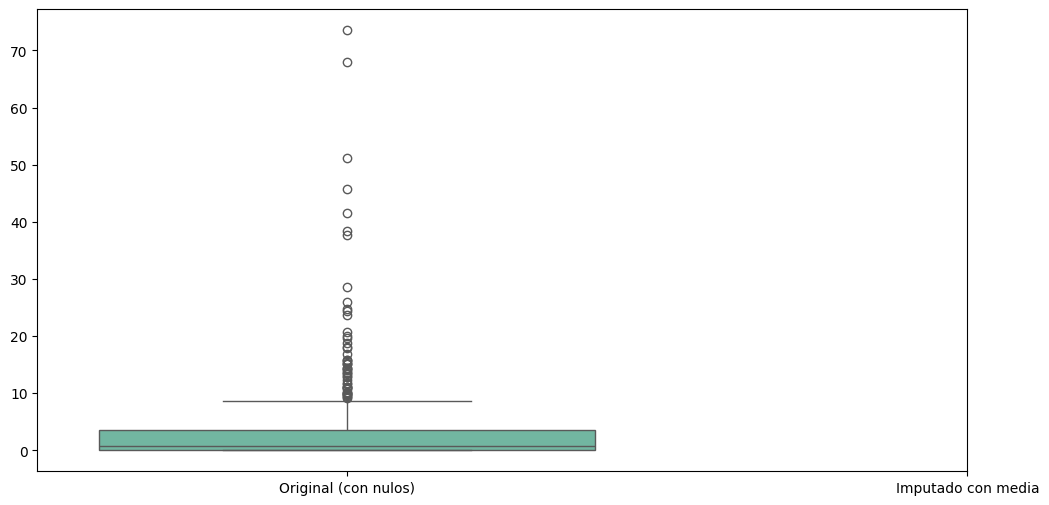

In [44]:
# boxplot para comparar distribución antes y después de imputación
plt.figure(figsize=(12, 6))
sns.boxplot(data=[df['CRIM'], df_copy_2['CRIM']], palette="Set2")
plt.xticks([0, 1], ['Original (con nulos)', 'Imputado con media'])
plt.show()

#### listwise / eliminar las filas de los datos

---

2. Eliminación (Deletion)

Esta técnica implica remover datos incompletos para trabajar solo con observaciones completas. Es simple y no introduce sesgos artificiales de imputación, pero puede reducir significativamente el tamaño del dataset, lo que es problemático si los datos son limitados o si los faltantes no son aleatorios (e.g., en MCAR es más seguro, pero en MAR puede sesgar hacia subgrupos con más datos completos).

**Listwise Deletion (Eliminación por Filas)**: Elimina cualquier fila que tenga al menos un valor faltante. Ideal cuando los faltantes son raros y el dataset es grande.

- Pros: Mantiene la integridad de los datos restantes; fácil de implementar.
- Contras: Pérdida de información valiosa; puede sesgar si faltantes están correlacionados con variables de interés.
- Cuándo usarla: Si <5-10% de los datos faltan y no hay patrones evidentes en los faltantes.

**Pairwise Deletion (Eliminación por Pares)**: No elimina filas enteras; en su lugar, ignora faltantes solo para cálculos específicos (e.g., en correlaciones, usa solo pares completos). No modifica el dataset original.
- Pros: Maximiza el uso de datos disponibles por análisis.
- Contras: Puede llevar a resultados inconsistentes (e.g., diferentes N por variable); no es ideal para modelado ML donde se necesita un dataset completo.

Cuándo usarla: En análisis exploratorios como correlaciones, no en preparación para modelos.

**Column Deletion (Eliminación por Columnas)**: Remueve columnas enteras con un alto porcentaje de faltantes.
- Pros: Simplifica el dataset si la columna no es crítica.
- Contras: Pierde variables potencialmente útiles; evalúa primero si la columna es redundante.
- Cuándo usarla: Si >50-70% faltan y la columna no es esencial (e.g., una variable auxiliar).
Consideraciones Prácticas:

Siempre calcula el impacto: Compara el tamaño del dataset antes/después (df.shape).

Combina con análisis: Verifica si la eliminación cambia distribuciones (e.g., con df.describe() antes y después).

Alternativa híbrida: Elimina filas solo si faltan en columnas clave, usando df.dropna(subset=['columna_importante']).

In [19]:
import pandas as pd
import numpy as np

# Dataset ficticio con faltantes
data = {
    'edad': [25, 30, np.nan, 40, 35, np.nan, 28, 50, 45, np.nan],
    'salario': [30000, np.nan, 45000, 50000, 35000, 40000, np.nan, 60000, 55000, 32000],
    'genero': ['M', 'F', 'F', None, 'M', 'F', 'M', 'F', None, 'M']
}
df = pd.DataFrame(data)

print("Dataset original:\n", df)
print("\nTamaño original:", df.shape)

# Listwise Deletion: Eliminar filas con cualquier faltante
df_listwise = df.dropna()
print("\nDespués de Listwise Deletion:\n", df_listwise)
print("Tamaño después:", df_listwise.shape)

# Pairwise Deletion: Ejemplo en correlación (no modifica df)
corr_pairwise = df.corr(method='pearson', numeric_only=True)  # Usa pares completos automáticamente
print("\nCorrelación con Pairwise Deletion:\n", corr_pairwise)

# Column Deletion: Eliminar columna si >20% faltan
threshold = len(df) * 0.20
df_column_drop = df.dropna(axis=1, thresh=threshold)  # thresh = mínimo no-faltantes
print("\nDespués de Column Deletion (umbral 80% completos):\n", df_column_drop)

Dataset original:
    edad  salario genero
0  25.0  30000.0      M
1  30.0      NaN      F
2   NaN  45000.0      F
3  40.0  50000.0   None
4  35.0  35000.0      M
5   NaN  40000.0      F
6  28.0      NaN      M
7  50.0  60000.0      F
8  45.0  55000.0   None
9   NaN  32000.0      M

Tamaño original: (10, 3)

Después de Listwise Deletion:
    edad  salario genero
0  25.0  30000.0      M
4  35.0  35000.0      M
7  50.0  60000.0      F
Tamaño después: (3, 3)

Correlación con Pairwise Deletion:
              edad   salario
edad     1.000000  0.964058
salario  0.964058  1.000000

Después de Column Deletion (umbral 80% completos):
    edad  salario genero
0  25.0  30000.0      M
1  30.0      NaN      F
2   NaN  45000.0      F
3  40.0  50000.0   None
4  35.0  35000.0      M
5   NaN  40000.0      F
6  28.0      NaN      M
7  50.0  60000.0      F
8  45.0  55000.0   None
9   NaN  32000.0      M
